# GradCAM - Gradient Class Activation Map

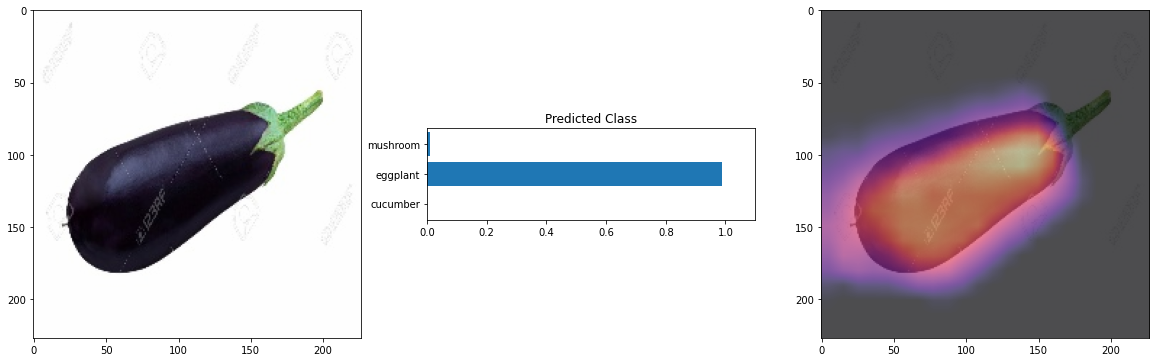

In [1]:
!git clone https://github.com/parth1620/GradCAM-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Cloning into 'GradCAM-Dataset'...
remote: Enumerating objects: 193, done.
remote: Counting objects: 100% (193/193), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 193 (delta 0), reused 193 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (193/193), 2.59 MiB | 1.66 MiB/s, done.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-1611arp1
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-1611arp1
  Resolved https://github.com/albumentations-team/albumentations to commit 20b99831beabb373fe04ec7521a41258e9faeab0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for albumentations: filename=albumentations-1.4.15-py3-none-any.whl size=210734 sha256=a5ca3134df96b78f01bcbd9a0ef5b17bf12330d9e9a08c664d5ccec706568b66
  Stored in directory: /tmp/pip-ephem-

# Imports

In [2]:
import sys
sys.path.append('/content/GradCAM-Dataset')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

# Configurations

In [4]:
CSV_FILE = '/content/GradCAM-Dataset/train.csv'
DATA_DIR = '/content/GradCAM-Dataset/'
DEVICE = 'cuda'
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 20

In [5]:
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [6]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = 42)

# Augmentations

In [7]:
train_augs = A.Compose([
    A.Rotate(),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

valid_augs = A.Compose([
    A.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])


# Load Image Dataset

In [8]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = valid_augs, data_dir = DATA_DIR)

Text(0.5, 1.0, 'eggplant')

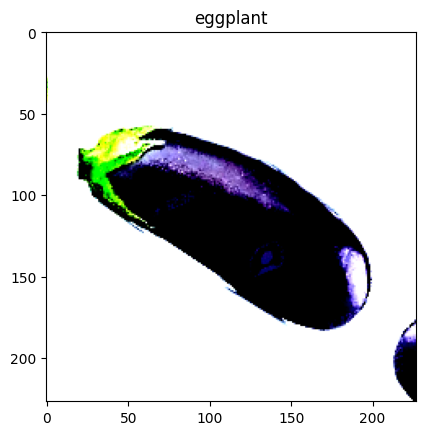

In [9]:
image, label = trainset[0] #(channel,height, width)
class_list = ['cucumber', 'eggplant', 'mushrooms']
plt.imshow(image.permute(1,2,0))  #(height, width, channel)
plt.title(class_list[label])

In [10]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


# Load Dataset into Batches

In [11]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [12]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 10
No. of batches in validloader : 3


In [13]:
for images, labels in trainloader:
  break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


# Create Model

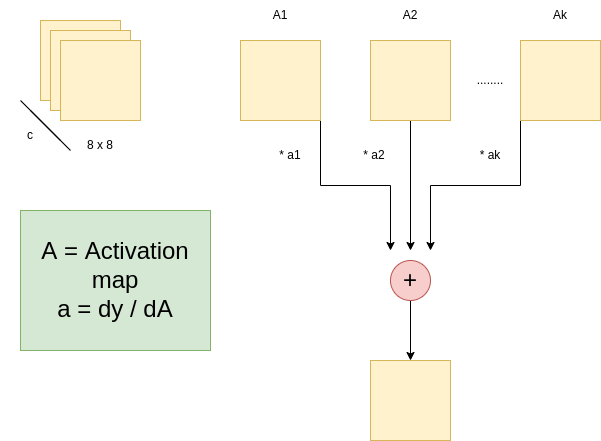

In [14]:
from torch.nn.modules.pooling import MaxPool2d
class ImageModel(nn.Module):

  def __init__(self):
    super(ImageModel, self).__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = (4, 4), stride = 2),

        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (5, 5), padding = 1),
        nn.ReLU(),
    )

    self.maxpool = nn.MaxPool2d(kernel_size = (4,4), stride = 2)

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(6400, 2048),
        nn.ReLU(),
        nn.Linear(2048,3)
    )

    self.gradient = None

  def activations_hook(self, grad):
    self.gradient = grad

  def forward(self, images):
    x = self.feature_extractor(images)    #activation_maps
    h = x.register_hook(self.activations_hook)
    x = self.maxpool(x)
    x = self.classifier(x)
    return x

  def get_activation_gradients(self):     #a1,a2,a3,....ak
    return self.gradient

  def get_activation(self,x):
    return self.feature_extractor(x)    #A1,A2,.....,AK -> (64,8,8) , 64 = # of channels

In [15]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

# Create Train and Eval function

In [16]:
def train_fn(dataloader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    optimizer.zero_grad()
    logits = model(images)
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  return total_loss/len(dataloader)

In [17]:
def eval_fn(dataloader, model, criterion):
  model.eval()
  total_loss = 0.0
  for images, labels in tqdm(dataloader):
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    logits = model(images)
    loss = criterion(logits, labels)

    total_loss += loss.item()
  return total_loss/len(dataloader)

# Training Loop

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

In [19]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer, criterion)
  valid_loss = eval_fn(validloader, model, criterion)

  if valid_loss<best_valid_loss:
    torch.save(model.state_dict(),'best_weights.pt')
    best_valid_loss = valid_loss
    print("Saved weights successfully")

  print(f'EPOCH : {i+1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}')

100%|██████████| 3/3 [00:00<00:00, 21.37it/s]


Saved weights successfully
EPOCH : 1 TRAIN LOSS : 1.079761618375778 VALID LOSS : 0.8691117167472839


100%|██████████| 3/3 [00:00<00:00, 17.17it/s]


Saved weights successfully
EPOCH : 2 TRAIN LOSS : 0.7151100009679794 VALID LOSS : 0.48947616418202716


100%|██████████| 3/3 [00:00<00:00, 27.31it/s]


EPOCH : 3 TRAIN LOSS : 0.574393056333065 VALID LOSS : 0.6435219397147497


100%|██████████| 3/3 [00:00<00:00, 22.17it/s]


Saved weights successfully
EPOCH : 4 TRAIN LOSS : 0.44265082776546477 VALID LOSS : 0.29390449821949005


100%|██████████| 3/3 [00:00<00:00, 14.21it/s]


EPOCH : 5 TRAIN LOSS : 0.36251669377088547 VALID LOSS : 0.5487247084577879


100%|██████████| 3/3 [00:00<00:00, 16.57it/s]


Saved weights successfully
EPOCH : 6 TRAIN LOSS : 0.24314224645495414 VALID LOSS : 0.19927903513113657


100%|██████████| 3/3 [00:00<00:00, 13.95it/s]


EPOCH : 7 TRAIN LOSS : 0.15659736469388008 VALID LOSS : 0.2805117027213176


100%|██████████| 3/3 [00:00<00:00, 20.65it/s]


Saved weights successfully
EPOCH : 8 TRAIN LOSS : 0.12650272939354182 VALID LOSS : 0.11823822154353063


100%|██████████| 3/3 [00:00<00:00, 26.43it/s]


EPOCH : 9 TRAIN LOSS : 0.12050622794777155 VALID LOSS : 0.5065354729692141


100%|██████████| 3/3 [00:00<00:00, 17.41it/s]


EPOCH : 10 TRAIN LOSS : 0.24232353458646685 VALID LOSS : 0.12594837447007498


100%|██████████| 3/3 [00:00<00:00, 25.34it/s]


Saved weights successfully
EPOCH : 11 TRAIN LOSS : 0.08256842605769635 VALID LOSS : 0.10855739563703537


100%|██████████| 3/3 [00:00<00:00, 24.17it/s]


EPOCH : 12 TRAIN LOSS : 0.08544611940160393 VALID LOSS : 0.17357221990823746


100%|██████████| 3/3 [00:00<00:00, 27.46it/s]


EPOCH : 13 TRAIN LOSS : 0.09546647671377287 VALID LOSS : 0.451257118023932


100%|██████████| 3/3 [00:00<00:00, 32.80it/s]


EPOCH : 14 TRAIN LOSS : 0.20351176001131535 VALID LOSS : 0.36320249115427333


100%|██████████| 3/3 [00:00<00:00, 25.15it/s]


EPOCH : 15 TRAIN LOSS : 0.182788987737149 VALID LOSS : 0.2083550455669562


100%|██████████| 3/3 [00:00<00:00, 13.64it/s]


EPOCH : 16 TRAIN LOSS : 0.06051361970603466 VALID LOSS : 0.1578564429655671


100%|██████████| 3/3 [00:00<00:00, 16.00it/s]


EPOCH : 17 TRAIN LOSS : 0.035823330469429496 VALID LOSS : 0.2856122098552684


100%|██████████| 3/3 [00:00<00:00, 30.72it/s]


EPOCH : 18 TRAIN LOSS : 0.01915016127168201 VALID LOSS : 0.1400562225850687


100%|██████████| 3/3 [00:00<00:00, 30.26it/s]


EPOCH : 19 TRAIN LOSS : 0.10041497871279717 VALID LOSS : 0.24595555663108826


100%|██████████| 3/3 [00:00<00:00, 45.55it/s]

EPOCH : 20 TRAIN LOSS : 0.053213249065447596 VALID LOSS : 0.15012575251360735


# Get GradCAM

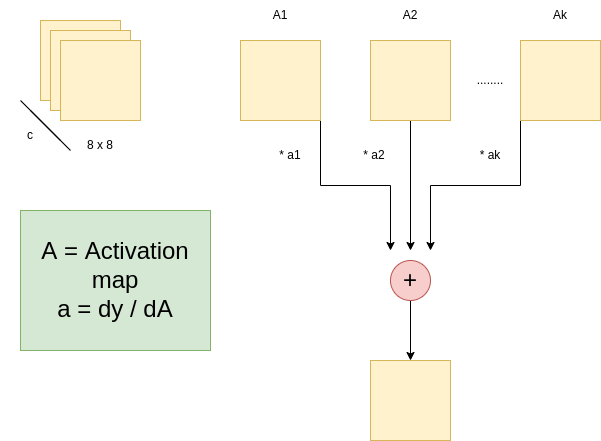

In [22]:
def get_gradcam(model, image, label, size):
  label.backward()
  gradients = model.get_activation_gradients()
  pooled_gradients = torch.mean(gradients, dim = [0,2,3]) #a1,a2,...ak
  activations = model.get_activation(image).detach() #A1,A2,....Ak

  for i in range(activations.shape[1]):
    activations[:,i,:,:] *= pooled_gradients[i]

  heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
  heatmap = nn.ReLU()(heatmap)
  heatmap /= torch.max(heatmap)
  heatmap = cv2.resize(heatmap.numpy(), (size,size))

  return heatmap

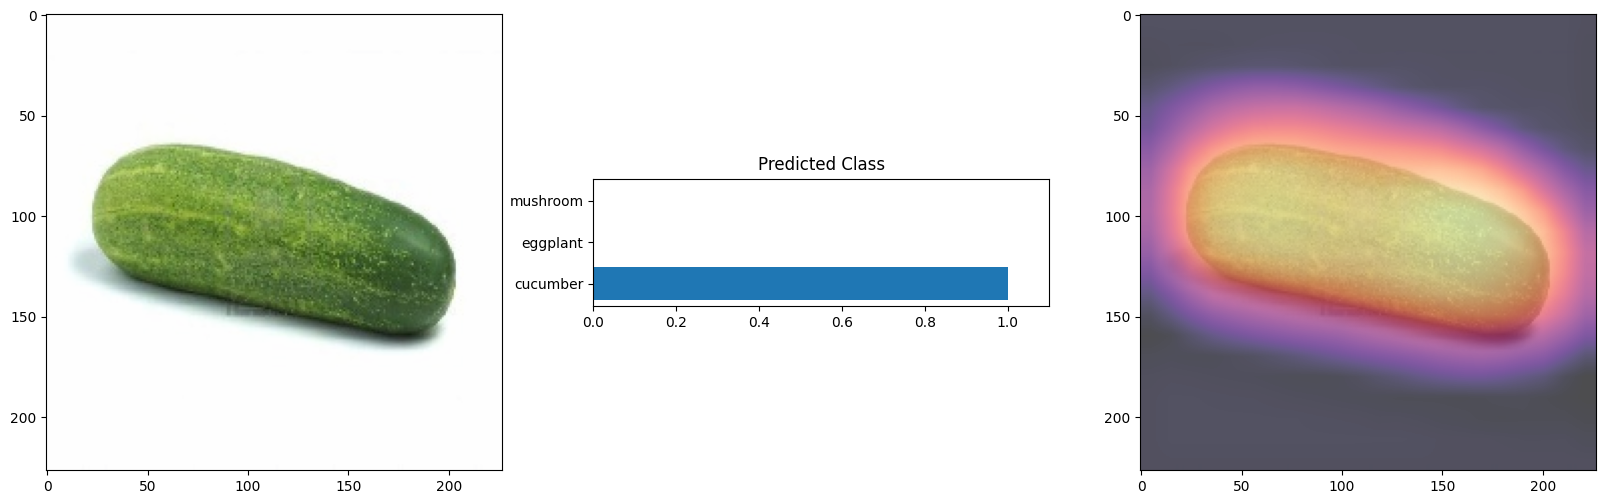

In [29]:
image, label = validset[7]

denorm_image = image.permute(1,2,0)*np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])

image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][0], size=227)
utils.plot_heatmap(denorm_image, pred, heatmap)